In [28]:
import requests
from datetime import date, timedelta
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
base_url = 'https://www.opcom.ro/rapoarte-pzu-raportPIP-export-csv/'

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2023,1,1)
end_date = date.today() + timedelta(days=1)

if not os.path.exists('./raw_folder'):
    os.makedirs('./raw_folder')

for single_date in daterange(start_date, end_date):
    date_str = '{d.day}/{d.month}/{d.year}'.format(d=single_date)
    response = requests.get(base_url+f'{date_str}/ro', verify=False)
    while response.status_code != 200:
        response = requests.get(base_url+f'{date_str}/ro', verify=False)
    lines = response.content.decode().splitlines()
    file_name = date_str.replace("/","-")
    with open(f'./raw_folder/{file_name}.csv', mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=',')
        for line in lines:
            row = line.split(',')
            writer.writerow(row)

In [17]:
mean_prices = {}
for csv in os.listdir('./raw_folder/'):
    df = pd.read_csv(f'./raw_folder/{csv}', skiprows=7)
    mean = df['"Pret de Inchidere a Pietei [lei/MWh]"'].apply(lambda x: float(x.strip('"'))).mean()
    mean_prices[csv[:-4]] = mean  

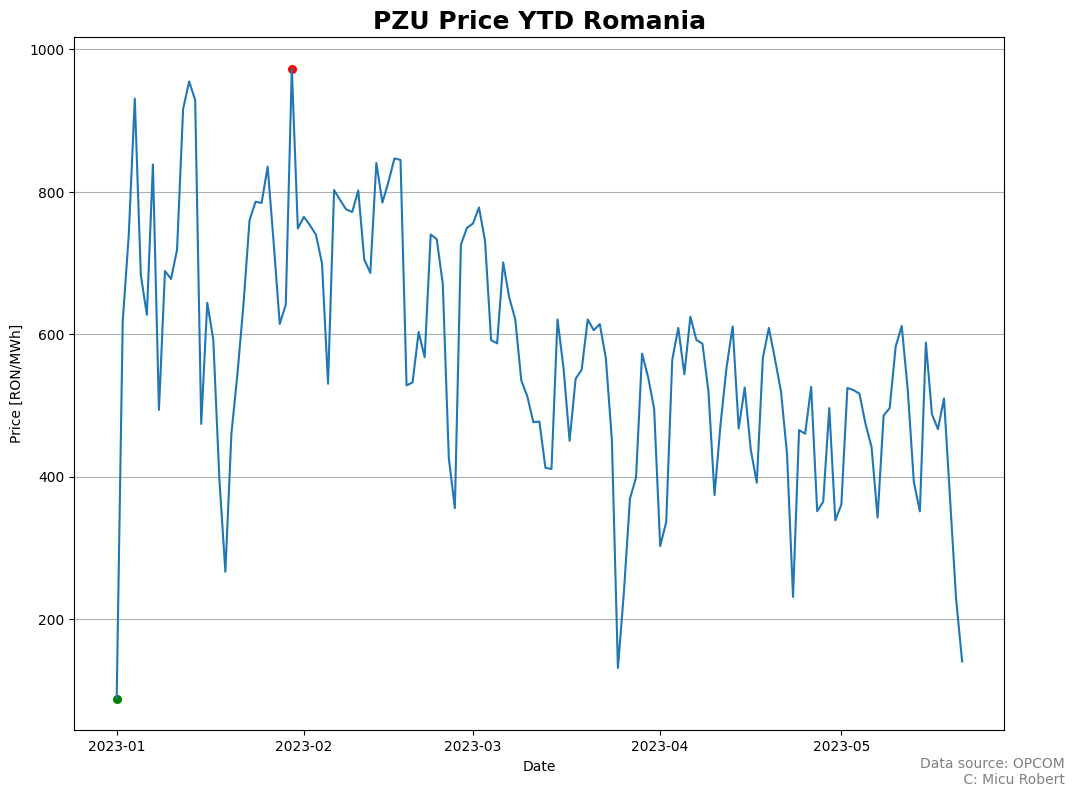

In [135]:
df = pd.DataFrame(mean_prices.items(), columns=['date', 'price'])
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.sort_values(by='date', inplace=True)

max_prices = df.groupby(df['date'].dt.year).apply(lambda x: x.loc[x['price'].idxmax()])
max_prices = max_prices.set_index(max_prices['date'].dt.date)
min_prices = df.groupby(df['date'].dt.year).apply(lambda x: x.loc[x['price'].idxmin()])
min_prices = min_prices.set_index(min_prices['date'].dt.date)

fig, ax = plt.subplots(figsize=(12,9))

ax.plot(df['date'], df['price'])

ax.scatter(max_prices['date'], max_prices['price'], s=30, color='red')
ax.scatter(min_prices['date'], min_prices['price'], s=30, color='green')

ax.grid(axis='y')

ax.set_xlabel('Date')
ax.set_ylabel('Price [RON/MWh]')
ax.set_title('PZU Price YTD Romania', fontsize=18, fontweight='bold')

plt.figtext(0.95, 0.05, 'Data source: OPCOM\n C: Micu Robert', horizontalalignment='right', fontsize=10, color='gray')

plt.show()


fig.savefig('PZU_price_graph_ytd')

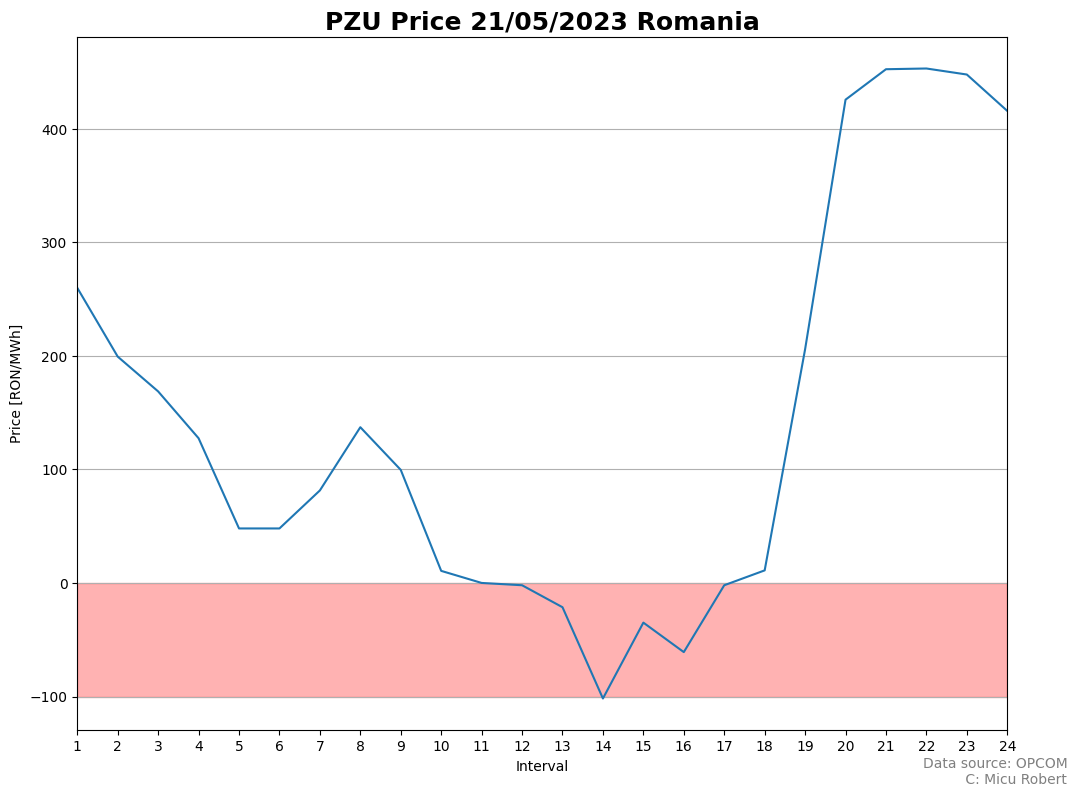

In [137]:
today = '{d.day}-{d.month}-{d.year}'.format(d=date.today())
df = pd.read_csv(f'./raw_folder/{today}.csv', skiprows=7)
df['"Pret de Inchidere a Pietei [lei/MWh]"'] = df['"Pret de Inchidere a Pietei [lei/MWh]"'].apply(lambda x: float(x.strip('"')))
df['"Interval"'] = df['"Interval"'].apply(lambda x: float(x.strip('"')))

fig, ax = plt.subplots(figsize=(12,9))

ax.plot(df['"Interval"'], df['"Pret de Inchidere a Pietei [lei/MWh]"'])
plt.xticks(df['"Interval"'])

ax.set_xlabel('Interval')
ax.set_ylabel('Price [RON/MWh]')
ax.set_title('PZU Price 21/05/2023 Romania', fontsize=18, fontweight='bold')

ax.axhspan(ymin=-100, ymax=0, color='red', alpha=0.3)

ax.margins(x=0)
ax.grid(axis='y')

plt.figtext(0.95, 0.05, 'Data source: OPCOM\n C: Micu Robert', horizontalalignment='right', fontsize=10, color='gray')

plt.show()

fig.savefig('PZU_price_graph_today')